In [1]:
# Notebook adapted from linear regression notebook from the Python Data Science Handbook
# Modified by: Gábor Major
# Last Modified date: 2024-10-08

In [2]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np
import pandas as pd

# Create n-th degree polynomial model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import pickle
poly_model = make_pipeline(PolynomialFeatures(8),
                           LinearRegression())


In [ ]:
# Import raw data
# To use already cleaned data skip down 6 cells
# Data from: https://data.gov.ie/dataset/dcc-scats-detector-volume-jan-jun-2023
traffic_data_list = pd.read_csv('data/SCATSFebruary2023.csv', sep=',', header=0, usecols=[0, 1, 2, 4, 5])

In [ ]:
print(traffic_data_list)
print(type(traffic_data_list))

In [ ]:
# Function for processing raw file
def sum_site_number_vaues(site_number, volume_list):
    specific_site_data = volume_data.loc[volume_data['Site'] == site_number]
    
    start_row_index = 0
    previous_time = specific_site_data.iloc[0, 0]
    region_code = specific_site_data.iloc[0, 1]
    row_index = 0
    
    for _, row in specific_site_data.iterrows():
        if row['End_Time'] != previous_time:
            volume_list.append([
                int(previous_time),
                region_code,
                int(site_number),
                int(specific_site_data.iloc[start_row_index:row_index, 3:4].sum().iloc[0]),
                int(specific_site_data.iloc[start_row_index:row_index, 4:5].sum().iloc[0])
            ])
            
            start_row_index = row_index
            previous_time = row['End_Time']
        
        row_index += 1

In [ ]:
from multiprocessing import Process, Manager
# Sum up data for each camera at each site
summed_traffic_volume_list = Manager().list()

site_numbers = traffic_data_list['Site'].unique()
process_list = []
counter = 0

for number in site_numbers:
    process = Process(target=sum_site_number_vaues, args=(number,summed_traffic_volume_list,))
    process_list.append(process)
    process.start()
    counter += 1
    if counter % 100 == 0:
        print(counter)

for process in process_list:
    process.join()

In [ ]:
print(len(summed_traffic_volume_list))

In [ ]:
# Save cleaned file
import csv
columns_names = ['End_Time', 'Region', 'Site', 'Sum_Volume', 'Avg_Volume']
with open('data/summed_data.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(columns_names)
    writer.writerows(summed_traffic_volume_list)

In [3]:
# Import cleaned data
cleaned_data = pd.read_csv('data/summed_data.csv', sep=',', header=0)
print(cleaned_data)

              End_Time Region  Site  Sum_Volume  Avg_Volume
0       20230228060000  CCITY   782           0           0
1       20230228050000  CCITY   782          90           7
2       20230228040000  CCITY   782         194          15
3       20230228030000  CCITY   782         121           9
4       20230228060000  CCITY   796         266          18
...                ...    ...   ...         ...         ...
611846  20230228110000    IRE  6381          86           4
611847  20230228100000    IRE  6381         105           5
611848  20230228090000    IRE  6381         133           8
611849  20230228080000    IRE  6381          74           3
611850  20230228070000    IRE  6381          65           3

[611851 rows x 5 columns]


In [4]:
# Convert End_Time to days and hours
all_times = cleaned_data['End_Time']
days = []
hours = []

for time in all_times:
    time = str(time)
    # year = time[:4]
    # month = time[4:6]
    days.append(time[6:8])
    hours.append(time[8:10])

cleaned_data['End_Day'] = days
cleaned_data['End_Hour'] = hours

In [5]:
print(cleaned_data)

              End_Time Region  Site  Sum_Volume  Avg_Volume End_Day End_Hour
0       20230228060000  CCITY   782           0           0      28       06
1       20230228050000  CCITY   782          90           7      28       05
2       20230228040000  CCITY   782         194          15      28       04
3       20230228030000  CCITY   782         121           9      28       03
4       20230228060000  CCITY   796         266          18      28       06
...                ...    ...   ...         ...         ...     ...      ...
611846  20230228110000    IRE  6381          86           4      28       11
611847  20230228100000    IRE  6381         105           5      28       10
611848  20230228090000    IRE  6381         133           8      28       09
611849  20230228080000    IRE  6381          74           3      28       08
611850  20230228070000    IRE  6381          65           3      28       07

[611851 rows x 7 columns]


In [6]:
# Sort data
cleaned_data_sorted = cleaned_data.sort_values('End_Hour')

In [7]:
def remove_outliers(data_in):
    removal_amount = 5
    upper_threshold = np.percentile(data_in['Sum_Volume'], 100 - removal_amount)
    lower_threshold = np.percentile(data_in['Sum_Volume'], removal_amount)
    return data_in.loc[data_in['Sum_Volume'] <= upper_threshold].loc[data_in['Sum_Volume'] >= lower_threshold]

In [8]:
# Get specific site
# To process all site jump down 8 cells
use_site = 782
site_data = cleaned_data_sorted.loc[cleaned_data_sorted['Site'] == use_site]
print(site_data)

              End_Time Region  Site  Sum_Volume  Avg_Volume End_Day End_Hour
90249   20230221000000  CCITY   782         333          25      21       00
139365  20230227000000  CCITY   782         309          23      27       00
50943   20230215000000  CCITY   782         373          29      15       00
147914  20230228000000  CCITY   782         315          24      28       00
83248   20230220000000  CCITY   782         326          25      20       00
...                ...    ...   ...         ...         ...     ...      ...
125902  20230224230000  CCITY   782         462          36      24       23
31594   20230211230000  CCITY   782         407          31      11       23
139318  20230226230000  CCITY   782         331          25      26       23
21692   20230209230000  CCITY   782         415          32      09       23
26618   20230210230000  CCITY   782         472          36      10       23

[672 rows x 7 columns]


In [9]:
# Remove the outliers for each hour
hours_data = []
for hour in range(24):
    if hour < 10:
        hour = '0' + str(hour)
    else:
        hour = str(hour)
    hour_data = site_data.loc[site_data['End_Hour'] == hour]
    if hour_data.empty:
        print('Not enough data!')
        break
    hours_data.append(remove_outliers(hour_data))

if len(hours_data) == 24:
    cleaned_site_data = pd.concat(hours_data)

672


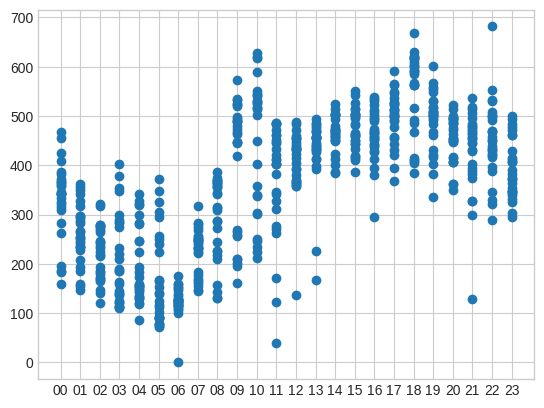

In [10]:
# Use End_Hour and Sum_Volume for calculating
x_data = site_data['End_Hour']
y_data = site_data['Sum_Volume']
# Show original data
x = x_data.to_numpy()
y = y_data.to_numpy()
print(len(y))
plt.scatter(x, y)

577


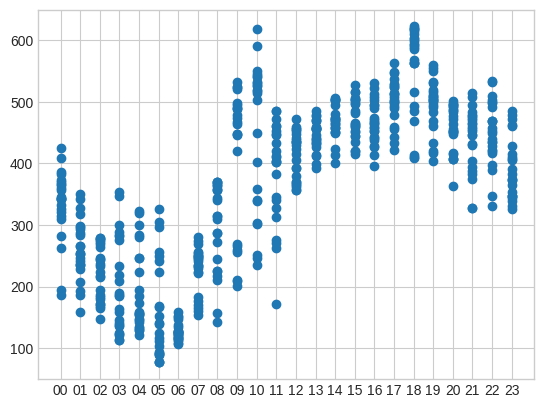

In [11]:
# Use End_Hour and Sum_Volume for calculating
x_data = cleaned_site_data['End_Hour']
y_data = cleaned_site_data['Sum_Volume']
# Show cleaned data
x = x_data.to_numpy()
y = y_data.to_numpy()
print(len(y))
plt.scatter(x, y)

In [12]:
# Fit data
poly_model.fit(x[:, np.newaxis], y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=8)),
                ('linearregression', LinearRegression())])

In [13]:
# Save model to disk
with open(f'models/site_{use_site}_model.pkl', 'wb') as f:
    pickle.dump(poly_model,f)

In [14]:
# Load in model
with open(f'models/site_{use_site}_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

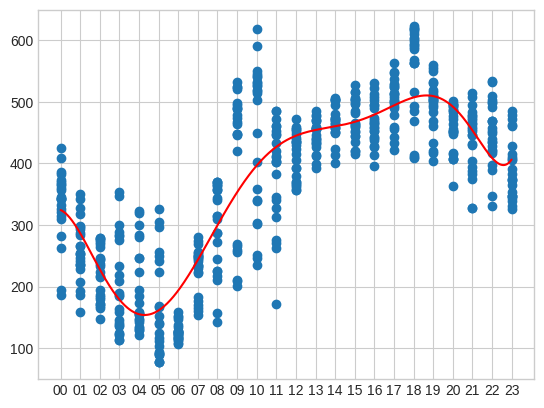

In [15]:
# Create test set
xfit = np.linspace(0, 23, 1000)
yfit = loaded_model.predict(xfit[:, np.newaxis])

# Plot data
plt.scatter(x, y)
plt.plot(xfit, yfit, color="red");

In [16]:
# Run for all sites
site_numbers = cleaned_data_sorted['Site'].unique()
for site in site_numbers:
    site_data = cleaned_data_sorted.loc[cleaned_data_sorted['Site'] == site]
    # Remove the outliers for each hour
    hours_data = []
    for hour in range(24):
        if hour < 10:
            hour = '0' + str(hour)
        else:
            hour = str(hour)
        hour_data = site_data.loc[site_data['End_Hour'] == hour]
        if hour_data.empty:
            print('Not enough data! - ' + str(site))
            break
        hours_data.append(remove_outliers(hour_data))
    
    if len(hours_data) != 24:
        continue
    
    hours_data = pd.concat(hours_data)
    
    # Use End_Hour and Sum_Volume for calculating
    x_data = hours_data['End_Hour']
    y_data = hours_data['Sum_Volume']
    # Show cleaned data
    x = x_data.to_numpy()
    y = y_data.to_numpy()

    # Fit data
    poly_model.fit(x[:, np.newaxis], y)

    # Save model to disk
    with open(f'models/site_{site}_model.pkl','wb') as f:
        pickle.dump(poly_model,f)

Not enough data! - 759
Not enough data! - 9997
Not enough data! - 9977
Not enough data! - 9987
Not enough data! - 9989
